# Convolutional Neural Network for Image Classification

The code below assumes Python 3.6 with Tensorflow installed.  

You may need to additionally install numpy, scipy, matplotlib, scikit-learn, seaborn, opencv-python, and pillow if you don't already have these installed.

### Dowload dataset
1. Download the Cifar-10 data <a>https://www.cs.toronto.edu/~kriz/cifar.html</a> and update PATH in cell [2].

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the Cifar-10 data

In [0]:
import os
import numpy as np
#import cPickle
import _pickle as cPickle
import pandas as pd 
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import backend as K
from keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler

In [0]:
class Cifar(object):
    def __init__(self, input_path, dropout_index):
        self.input_path = input_path
        self.dropout_index = dropout_index
        self._get_data()
    
    @staticmethod
    def _unpickle(file):
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo, encoding='latin1')
        return dict
    
    @staticmethod
    def _getfiles(path):
        files = []
        for file in os.listdir(path):
            if "data_batch" in file:
                files.append(file)
        return files
 
    def _get_data(self):

        cifar_9_data = []
        cifar_9_labels = []
        cifar_1_data = []
        cifar_1_labels = []
        cifar_data_all = []
        cifar_lebels_all = []
        files = self._getfiles(self.input_path)

        for batch_file in files:
            batch = self._unpickle('{0}/{1}'.format(PATH, batch_file))
            labels = np.array(batch['labels'])
            keep_indexs = np.zeros(len(labels), dtype=bool)
            keep_indexs[labels!=self.dropout_index] = True
            cifar_9_data.append(batch['data'][keep_indexs])
            cifar_9_labels.append(labels[keep_indexs])
            drop_indexs = np.invert(keep_indexs)
            cifar_1_data.append(batch['data'][drop_indexs])
            cifar_1_labels.append(labels[drop_indexs])
            cifar_data_all.append(batch['data'])
            cifar_lebels_all.append(labels)

        cifar_9_data = np.transpose(np.concatenate(cifar_9_data).reshape(-1,3,32,32), (0, 2, 3, 1))
        cifar_9_labels = np.concatenate(cifar_9_labels)
        cifar_1_data = np.transpose(np.concatenate(cifar_1_data).reshape(-1,3,32,32), (0, 2, 3, 1))
        cifar_1_labels = np.concatenate(cifar_1_labels)
        cifar_data_all = np.transpose(np.concatenate(cifar_data_all).reshape(-1,3,32,32), (0, 2, 3, 1))
        cifar_lebels_all = np.concatenate(cifar_lebels_all)
        
#         self.data = cifar_9_data.astype('float32')/255
#         self.labels = tensorflow.keras.utils.to_categorical(cifar_9_labels, 10)
        self.data = cifar_data_all.astype('float32')/255
        self.labels = tensorflow.keras.utils.to_categorical(cifar_lebels_all, 10)  
#         mean = np.mean(cifar_data_all,axis=(0, 2, 3, 1))
#         std = np.std(cifar_data_all,axis=(0, 2, 3, 1))
#         self.data = (cifar_data_all-mean)/(std+1e-7)   
#         self.trans_data = cifar_1_data.astype('float32')/255
#         self.trans_labels = tensorflow.keras.utils.to_categorical(cifar_1_labels, 10)
        
    def next_data_batch(self, num):
        idx = np.arange(0, len(self.labels))
        np.random.shuffle(idx)
        idx = idx[:num]
        
        return self.data[idx], self.labels[idx]
        
    def next_trans_data_batch(self, num):
        idx = np.arange(0, len(self.trans_labels))
        np.random.shuffle(idx)
        idx = idx[:num]
        batch = self.data[idx]
        
        return self.trans_data[idx], self.trans_labels[idx]

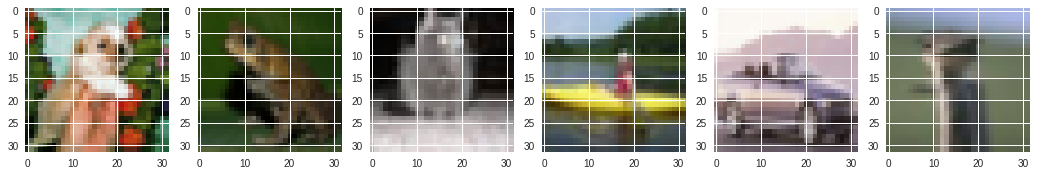

In [75]:
PATH = "/content/drive/My Drive/Dataset/cifar-10-batches-py/"
cifar = Cifar(PATH, 9)
data,labels = cifar.next_data_batch(6)
plt.figure(figsize=(18, 10))
#plt.figure()
reference = data
for i in range(reference.shape[0]):
    plt.subplot(int(reference.shape[0]/6)+1, 6, i+1)
    plt.imshow(reference[i])
    
plt.show()

## Define Keras deep net model and train

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

In [0]:
num_classes = 10
epochs = 150 # 50 is required for your final submission, but you can decrease for quick testing
weight_decay = 1e-4
x_train = cifar.data[:32000]
y_train = cifar.labels[:32000]
x_val = cifar.data[32000:40000]
y_val = cifar.labels[32000:40000]
x_test = cifar.data[40000:]
y_test = cifar.labels[40000:]

In [0]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

#model.summary()

In [81]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(x_train)

#training
batch_size = 64

opt_rms = tensorflow.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=2,validation_data=(x_val,y_val), callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/150
8000/8000 [==============================] - 2s 279us/sample - loss: 0.9429 - acc: 0.7279
 - 28s - loss: 0.8593 - acc: 0.7349 - val_loss: 0.9429 - val_acc: 0.7279
Epoch 2/150
8000/8000 [==============================] - 2s 222us/sample - loss: 0.9439 - acc: 0.7266
 - 27s - loss: 0.8318 - acc: 0.7454 - val_loss: 0.9439 - val_acc: 0.7266
Epoch 3/150
8000/8000 [==============================] - 2s 223us/sample - loss: 0.8176 - acc: 0.7675
 - 27s - loss: 0.8138 - acc: 0.7554 - val_loss: 0.8176 - val_acc: 0.7675
Epoch 4/150
8000/8000 [==============================] - 2s 217us/sample - loss: 0.8936 - acc: 0.7492
 - 27s - loss: 0.7890 - acc: 0.7643 - val_loss: 0.8936 - val_acc: 0.7492
Epoch 5/150
8000/8000 [==============================] - 2s 219us/sample - loss: 0.8350 - acc: 0.7679
 - 27s - loss: 0.7780 - acc: 0.7712 - val_loss: 0.8350 - val_acc: 0.7679
Epoch 6/150
8000/8000 [==============================] - 2s 221us/sample - loss: 0.8060 - acc: 0.7779
 - 27s - loss: 0.7586 -

## Show train and test performance vs. epochs of gradient descent training

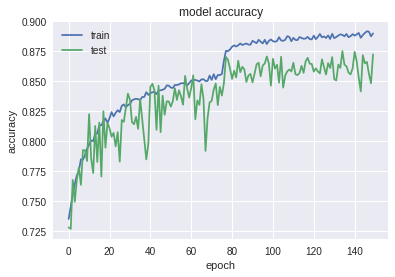

In [82]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Label Names(not gaven as metadata)
Label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
    ]
y_pred = np.argmax(model.predict(x_test), axis=1)   
y_label = np.argmax(y_test,axis=1)

In [84]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 2s 169us/sample - loss: 0.4858 - acc: 0.8797

Test result: 87.970 loss: 0.486


In [0]:
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

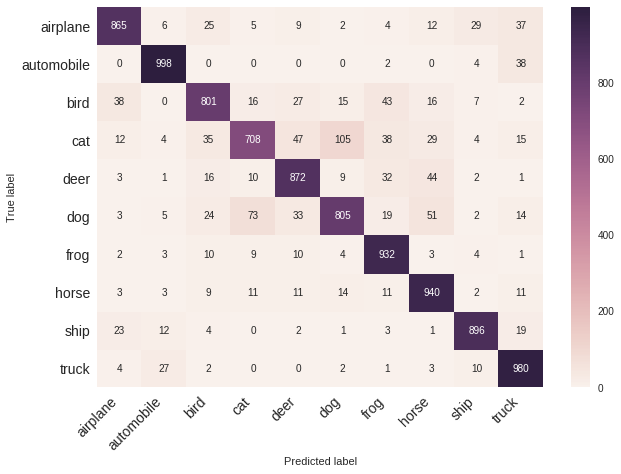

In [86]:
#  Cifar-9 Confusion Matrix
print_confusion_matrix(confusion_matrix(y_label, y_pred), 
                       Label_names)

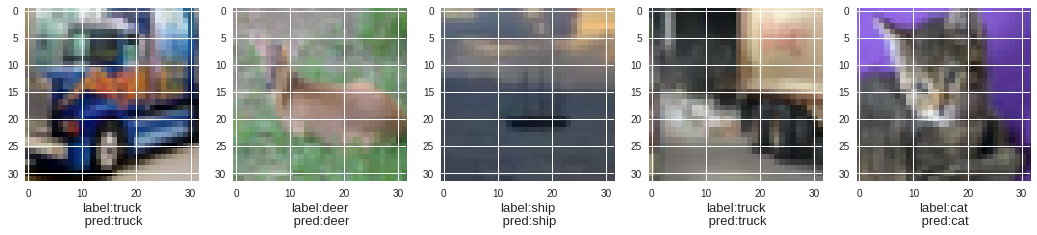

In [87]:
def random_examples(image, label, predict, Label_names, sample_size=5):
    plt.figure(figsize=(18, 10))
    reference = image[:sample_size]
    for i in range(reference.shape[0]):
        plt.subplot(int(reference.shape[0]/sample_size)+1, 
                    sample_size, i+1)
        plt.imshow(reference[i])
        plt.xlabel('label:{0}\n pred:{1}'.format(Label_names[label[i]],
                                                 Label_names[pred[i]]), 
                   fontsize=13)
    plt.show()
image,label = cifar.next_data_batch(5)
label = np.argmax(label, axis=1)
pred = np.argmax(model.predict(image), axis=1)
random_examples(image, label, pred, Label_names)

## Summary of modification 
### Data
- In order to make good use of the dataset, I use all categories(10) rather than 9
- Total we have 50K data and I split them into 40K training (32k training, 8k validate) and 10k testing

### Model
- The old moddel is 32-32-64-64, I add two more convolutional layers and it becomes 32-32-64-64-128-128 to increase the capacity of the model. But once we add more parameters, we need to deal with overfitting. 
- Tuned dropout rate for each layers
- Add L2 weight decay to every convolutional layer to prevent overfitting
- Add Batch Normalization after every convolutional layer (https://keras.io/layers/normalization/)
- Investigated should add Batch Norm layer before or after non-linear layers and found that after non-linear layers is better (https://forums.fast.ai/t/questions-about-batch-normalization/230/2)
- Tried relu and elu and found that elu converges a little bit faster
- Using Data Augmentation Techniques to overcome this problem of limited quantity and limited diversity of data(https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9)
- Use adaptive learning rate to avoid miss of minimum point. (https://www.quora.com/Why-do-we-need-adaptive-learning-rates-for-Deep-Learning)
- Change batch size from 128 to 64. It requires more time to converge but get better test accuracy performance.


### Performance
- Test on 10k unseen testing set and get (Test result: 87.970 loss: 0.486)
- Both training and validation accuracies are still increasing at 150 epochs. I believe we can get around 90% if I train 200 epochs.